In [9]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import os.path as osp

# 导入模块
import time
from sklearn import cluster
from sklearn.cluster import KMeans
from collections import Counter
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import shap

source_dir = osp.join(osp.abspath('..'), 'data', 'source')


def read_index(type, header='appliance'):
    """
    读取给定type所包含的样本序号。如：读取load里面'R','I','NL'对应的设备序号有哪些
    :param type: 需要查询的标签名
    :param header: 对应的json里面的键，默认appliance
    """
    with open(osp.join(source_dir, 'metadata_submetered2.1.json'),
              'r',
              encoding='utf8') as load_meta:
        meta = json.load(load_meta)
        metadata_len = len(meta)
        label_index = {}
        for i in range(metadata_len):
            try:
                label = meta[str(i + 1)][header][str(type)]
            except NameError:
                print('第{}个样本没有属性{}'.format(i + 1, type))
            else:
                if label in label_index.keys():
                    label_index[label].append(i + 1)
                else:
                    label_index[label] = [i + 1]
        return label_index


# test read_index
# ri = read_index('type', header="appliance")
# print(ri)


def read_correlation(name,
                     type,
                     name_header='appliance',
                     type_header='appliance'):

    with open(osp.join(source_dir, 'metadata_submetered2.1.json'),
              'r',
              encoding='utf8') as load_meta:
        meta = json.load(load_meta)
        metadata_len = len(meta)
        name_type = {}
        for i in range(metadata_len):
            try:
                name_label = meta[str(i + 1)][name_header][str(name)]
                type_label = meta[str(i + 1)][type_header][str(type)]
            except NameError:
                print('第{}个样本没有属性{}或{}'.format(i + 1, name, type))
            else:
                if name_label in name_type.keys():
                    if type_label in name_type[name_label]:
                        continue
                    else:
                        name_type[name_label].append(type_label)
                else:
                    name_type[name_label] = []
                    name_type[name_label].append(type_label)
        return name_type


# test
# rc = read_correlation('type', 'brand')
# print(rc)


def read_processed_data(type,
                        type_header='appliance',
                        selected_label=[],
                        offset=0,
                        direaction=0,
                        each_lenth=1,
                        feature_select=None,
                        Transformer=None,
                        source='submetered_process',
                        json_name='metadata_submetered2.1.json'):
    file_dir = osp.join(source_dir, source)
    json_dir = osp.join(source_dir, json_name)
    meta = None
    with open(json_dir, 'r', encoding='utf8') as load_meta:
        meta = json.load(load_meta)

    csv_list = os.listdir(file_dir)
    first_data = pd.read_csv(os.path.join(file_dir, csv_list[0]))
    features = first_data.keys()
    feature_len = 0
    if feature_select is not None:
        try:
            feature_index = features.get_indexer(feature_select)
            feature_index = feature_index.tolist()
        except IndexError:
            print('there is no feature-selected in data')
    if feature_select is None:
        feature_len = len(features)
    else:
        try:
            feature_len = len(feature_select)
        except TypeError:
            print('feature_select需为所选特征数组')
    x = np.zeros((len(csv_list) * each_lenth, feature_len))
    y = np.zeros((len(csv_list) * each_lenth))
    index = np.zeros((len(csv_list) * each_lenth, 2))
    for i, file in enumerate(csv_list):
        if feature_select is None:
            data = pd.read_csv(os.path.join(file_dir, file))
        else:
            data = pd.read_csv(
                os.path.join(file_dir, file),
                usecols=feature_index,
            )
        num = file[0:-4]
        data_len = len(data)
        try:
            label = meta[num][type_header][type]
        except TypeError:
            print('没有该属性')
        if selected_label != []:
            if label not in selected_label:
                continue
        if direaction == 0:
            for j in range(each_lenth):
                x[i * each_lenth + j, :] = data.loc[offset + j]
                index[i * each_lenth + j, 0] = num
                index[i * each_lenth + j, 1] = offset + j
                if Transformer is not None:
                    y[i * each_lenth + j] = Transformer[label]
                else:
                    y = y.astype(np.str)
                    y[i * each_lenth + j] = label
        else:
            for j in range(each_lenth):
                x[i * each_lenth + j, :] = data.loc[data_len - offset - j - 1]
                index[i * each_lenth + j, 0] = num
                index[i * each_lenth + j, 1] = data_len - offset - j + 1
                if Transformer is not None:
                    y[i * each_lenth + j] = Transformer[label]
                else:
                    y = y.astype(np.str)
                    y[i * each_lenth + j] = label
    idx = np.argwhere(np.all(x[:, ...] == 0, axis=1))
    x = np.delete(x, idx, axis=0)
    y = np.delete(y, idx, axis=0)
    index = np.delete(index, idx, axis=0)
    x = np.nan_to_num(x)
    x[x > 10000] = 10000
    return x, y, index


def get_feature_name(dir='submetered_process2'):
    dir = osp.join(source_dir, dir)
    csv_list = os.listdir(dir)
    first_file = pd.read_csv(os.path.join(dir, csv_list[0]))
    features = first_file.keys()
    features = list(features)
    del features[0]
    return features


# 输入点列表，返回所有边
def calc_edge(Node_list):
    edge_list = []
    for node_A in Node_list:
        for node_B in Node_list:
            if node_B == node_A:
                continue
            edge_list.append(node_A + ',' + node_B)
    return edge_list


# 记录边的重复出现次数
def count_edge(edge_count_dict, edge_list):
    for edge in edge_list:
        if edge not in edge_count_dict.keys():
            edge_count_dict[edge] = 1
        else:
            edge_count_dict[edge] += 1
    return edge_count_dict  # key为边，格式为'%03d,%03d'；value为出现的次数


# 记录点的重复出现次数
def count_node(node_count_dict, node_list):  # node为字符串型
    for node in node_list:
        if node not in node_count_dict.keys():
            node_count_dict[node] = 1
        else:
            node_count_dict[node] += 1
    return node_count_dict


def save_graph_in_txt(file_dir, node_counts, edge_counts, graph_label) -> None:
    with open(osp.join(file_dir, 'PLAIDG_node_labels.txt'),
              'r') as file_node_labels:
        base_node_num = len(file_node_labels.readlines())
    with open(osp.join(file_dir, 'PLAIDG_graph_labels.txt'),
              'r') as file_graph_label:
        base_graph_num = len(file_graph_label.readlines())
    with open(osp.join(file_dir, 'PLAIDG_graph_labels.txt'),
              'a') as file_graph_label:
        file_graph_label.write(str(graph_label) + '\n')
    tmp = 1
    index_convert = {}
    for key in node_counts.keys():  # key为节点类型，变成label；value为次数，变成attribute
        feat = key.split(':')[0]
        cluster = key.split(':')[1]
        with open(osp.join(file_dir, 'PLAIDG_node_labels.txt'),
                  'a') as file_node_labels:
            # file_node_labels.write(str(key) + '\n')  #指示当前节点的标签（特征+中心所对应的编号）
            file_node_labels.write(str(feat) + '\n')
        with open(osp.join(file_dir, 'PLAIDG_node_attributes.txt'),
                  'a') as file_node_attributes:
            file_node_attributes.write(str(cluster) + '\n')  # 指示当前节点的聚类值
        with open(osp.join(file_dir, 'PLAIDG_graph_indicator.txt'),
                  'a') as file_graph_indicator:
            file_graph_indicator.write(str(base_graph_num + 1) +
                                       '\n')  # 指示当前节点属于第几个graph
        index_convert[key] = str(base_node_num + tmp)  # 用于描述A矩阵，重新定义边的节点编号
        tmp += 1
    for key in edge_counts.keys():  # key为节点对，变成A阵；value为次数，变成attribute
        key_str = key.split(',')
        node_a = index_convert[key_str[0]]
        node_b = index_convert[key_str[1]]
        with open(osp.join(file_dir, 'PLAIDG_A.txt'), 'a') as file_A:
            file_A.write(node_b + ',' + node_a + '\n')  # 通用数据集都是第二列顺序排列的
        with open(osp.join(file_dir, 'PLAIDG_edge_attributes.txt'),
                  'a') as file_edge_attributes:
            file_edge_attributes.write(str(edge_counts[key]) + '\n')


def generate_graph(x, y, dst_dir):
    file_count = 0
    for i, x_i_cluster in enumerate(x):
        edge_counts = {}
        node_counts = {}
        y_label_tmp = y[i]
        nodes_temp = []

        for j, cluster_k in enumerate(x_i_cluster):  # j为特征编号,cluster_k为所属类别
            cluster_k = int(cluster_k)
            nodes_temp.append('%02d:%02d' % (j, cluster_k))  # 节点编号为1-30

        # calc edge
        edge_list = calc_edge(nodes_temp)
        edge_counts = count_edge(edge_counts, edge_list)
        # calc node
        node_counts = count_node(node_counts, nodes_temp)
        save_graph_in_txt(dst_dir, node_counts, edge_counts, y_label_tmp)
        # if i % each_file_len == (each_file_len - 1):
        file_count += 1
        if i % 100 == 0:
            print('%04d/%04d' % (file_count, int(len(y) / each_file_len)))


finished loading data, cost 9.717s
Original Accuracy : 0.8222


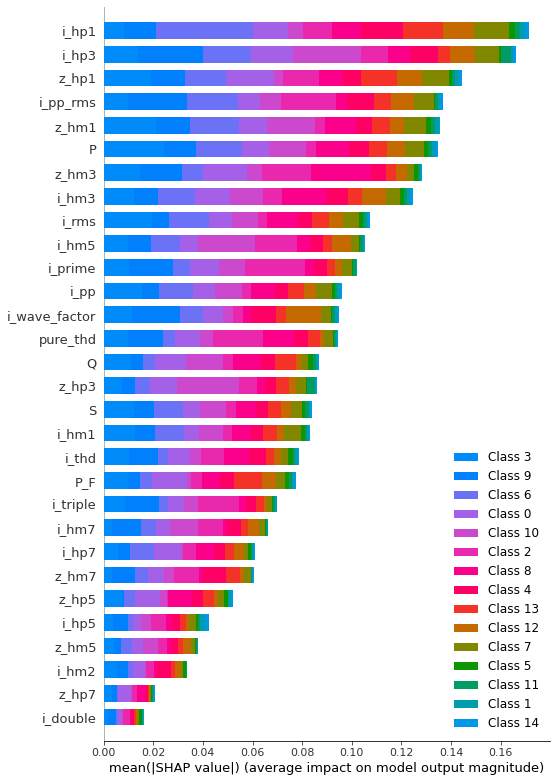

In [8]:

# 读取数据

start_reading_time = time.time()
source_file_pack = 'submetered_zengj'
# feature_select = [
#     'i_mean', 'i_wave_factor', 'i_pp_rms', 'i_thd', 'pure_thd', 'P', 'Q',
#     'P_F', 'i_hp1', 'z_hp1', 'i_hm2', 'z_hm2', 'i_hp2', 'z_hp2', 'i_hm3',
#     'z_hm3', 'i_hp3', 'z_hp3', 'i_hm4', 'z_hm4', 'i_hp4', 'z_hp4', 'i_hm5',
#     'z_hm5', 'i_hp5', 'z_hp5', 'i_hm6', 'z_hm6', 'i_hp6', 'z_hp6', 'i_hm7',
#     'z_hm7', 'i_hp7', 'z_hp7'
# ]  # 选择所用特征量

feature_select = get_feature_name(dir=osp.join(source_file_pack, 'total'))

selected_label = [
    'Air Conditioner', 'Blender', 'Coffee maker', 'Compact Fluorescent Lamp',
    'Fan', 'Fridge', 'Hair Iron', 'Hairdryer', 'Heater',
    'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Soldering Iron',
    'Vacuum', 'Washing Machine', 'Water kettle'
]  # 选择所用电器

load_transformer = {}
num = 0
for item in selected_label:
    load_transformer[item] = num
    num += 1

each_file_len = 20

x_train, y_train, index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=each_file_len,
    feature_select=feature_select,
    Transformer=load_transformer,
    source=osp.join(source_file_pack, 'training'))  # 读取训练数据
y_train = y_train.reshape(-1, 1)

x_validation, y_validation, index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=each_file_len,
    feature_select=feature_select,
    Transformer=load_transformer,
    source=osp.join(source_file_pack, 'validation'))  # 读取验证数据
y_validation = y_validation.reshape(-1, 1)

x_trainval = np.concatenate((x_train, x_validation), axis=0)
y_trainval = np.concatenate((y_train, y_validation), axis=0)
y_trainval = y_trainval.ravel()

x_test, y_test, index_test = read_processed_data('type',
                                                 type_header='appliance',
                                                 selected_label=selected_label,
                                                 direaction=1,
                                                 offset=0,
                                                 each_lenth=each_file_len,
                                                 feature_select=feature_select,
                                                 Transformer=load_transformer,
                                                 source=osp.join(
                                                     source_file_pack,
                                                     'testing'))  # 读取测试数据
y_test = y_test.ravel()
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))


# 原始数据进行随机深林
rf_base = RandomForestClassifier()
rf_base.fit(x_trainval, y_trainval)
y_test_pred = rf_base.predict(x_test)
print("Original Accuracy : %.4g" % metrics.accuracy_score(y_test, y_test_pred))
explainer = shap.TreeExplainer(rf_base)
shap_values = explainer.shap_values(x_trainval)
shap.summary_plot(shap_values, feature_select, plot_type='bar', max_display=30)

原始数据进行集成学习，观察每个变量的shap值

In [9]:
# 读取数据

start_reading_time = time.time()
source_file_pack = 'submetered_zengj'
# feature_select = [
#     'i_mean', 'i_wave_factor', 'i_pp_rms', 'i_thd', 'pure_thd', 'P', 'Q',
#     'P_F', 'i_hp1', 'z_hp1', 'i_hm2', 'z_hm2', 'i_hp2', 'z_hp2', 'i_hm3',
#     'z_hm3', 'i_hp3', 'z_hp3', 'i_hm4', 'z_hm4', 'i_hp4', 'z_hp4', 'i_hm5',
#     'z_hm5', 'i_hp5', 'z_hp5', 'i_hm6', 'z_hm6', 'i_hp6', 'z_hp6', 'i_hm7',
#     'z_hm7', 'i_hp7', 'z_hp7'
# ]  # 选择所用特征量

feature_select = get_feature_name(dir=osp.join(source_file_pack, 'total'))

selected_label = [
    'Air Conditioner', 'Blender', 'Coffee maker', 'Compact Fluorescent Lamp',
    'Fan', 'Fridge', 'Hair Iron', 'Hairdryer', 'Heater',
    'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Soldering Iron',
    'Vacuum', 'Washing Machine', 'Water kettle'
]  # 选择所用电器

load_transformer = {}
num = 0
for item in selected_label:
    load_transformer[item] = num
    num += 1


x_train, y_train, index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=each_file_len,
    feature_select=feature_select,
    Transformer=load_transformer,
    source=osp.join(source_file_pack, 'training'))  # 读取训练数据
y_train = y_train.reshape(-1, 1)

x_validation, y_validation, index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=each_file_len,
    feature_select=feature_select,
    Transformer=load_transformer,
    source=osp.join(source_file_pack, 'validation'))  # 读取验证数据
y_validation = y_validation.reshape(-1, 1)

x_trainval = np.concatenate((x_train, x_validation), axis=0)
y_trainval = np.concatenate((y_train, y_validation), axis=0)
y_trainval = y_trainval.ravel()

x_test, y_test, index_test = read_processed_data('type',
                                                 type_header='appliance',
                                                 selected_label=selected_label,
                                                 direaction=1,
                                                 offset=0,
                                                 each_lenth=each_file_len,
                                                 feature_select=feature_select,
                                                 Transformer=load_transformer,
                                                 source=osp.join(
                                                     source_file_pack,
                                                     'testing'))  # 读取测试数据
y_test = y_test.ravel()
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))


# 特征值聚类识别
center_record = {}
centers = {}
feature_lens = 30  # 应该改成len函数取值

for n_cluster in range(2, 20):
    data_train = y_trainval.reshape(-1, 1)
    data_test = y_test.reshape(-1, 1)
    for f_index in range(feature_lens):  #
        # n_cluster = 4 * (2 * feature_lens - 2 * f_index) - 4 # 按照数圈的方式制定聚类中心
        # n_cluster = 20
        km = KMeans(n_clusters=n_cluster, random_state=1)
        if f_index in [5, 6]:  # 只有这两个特征（功率）需要取对数
            x_trainval_f = np.log(x_trainval[:, f_index]).reshape(-1, 1)
            x_test_f = np.log(x_test[:, f_index]).reshape(-1, 1)
        x_trainval_f = x_trainval[:, f_index].reshape(-1, 1)
        x_test_f = x_test[:, f_index].reshape(-1, 1)
        # 对训练集进行聚类
        x_trainval_cluster = km.fit_predict(x_trainval_f).reshape(
            -1, 1)  # 这里的y只是kmean里面的聚类中心编号，不是从小到大排列下来的编号
        data_train = np.concatenate((data_train, x_trainval_cluster), axis=1)
        # 对测试集进行聚类转化
        x_test_cluster = km.predict(x_test_f).reshape(-1, 1)  # 直接预测就行，不需要fit
        data_test = np.concatenate((data_test, x_test_cluster), axis=1)
        # 记录聚类中心和排序
        centers[f_index] = [i for item in km.cluster_centers_
                            for i in item]  # item是个数组，如果只有1维，再加个循环读取数值
        center_record[f_index] = np.argsort(
            centers[f_index]
        )  # 对kmeans得到的聚类中心从小到大进行排序，得到排序index，即center[record[0]]为中心最小值

    rf_cluster = RandomForestClassifier()
    rf_cluster.fit(data_train[:, 1:], data_train[:, 0])
    y_test_pred = rf_cluster.predict(data_test[:, 1:])
    print("%02d: Cluster Accuracy : %.4g" %
          (n_cluster, metrics.accuracy_score(data_test[:, 0], y_test_pred)))

finished loading data, cost 31.546s
01: Cluster Accuracy : 0.1312
02: Cluster Accuracy : 0.5992
03: Cluster Accuracy : 0.7515
04: Cluster Accuracy : 0.7212
05: Cluster Accuracy : 0.792
06: Cluster Accuracy : 0.7739
07: Cluster Accuracy : 0.7752
08: Cluster Accuracy : 0.7501
09: Cluster Accuracy : 0.7564
10: Cluster Accuracy : 0.7996
11: Cluster Accuracy : 0.7742
12: Cluster Accuracy : 0.7445
13: Cluster Accuracy : 0.7953
14: Cluster Accuracy : 0.7237
15: Cluster Accuracy : 0.7307
16: Cluster Accuracy : 0.7082
17: Cluster Accuracy : 0.7115
18: Cluster Accuracy : 0.6796
19: Cluster Accuracy : 0.7066


对所有的变量进行聚类再来进行集成学习，并没有多大改善。原因是集成学习本身就含有大量分箱的操作，进行聚类有些多此一举。尝试一下对聚类的数据进行构图。

构图的思路是，节点顺序为特征顺序，特征为聚类点，边为啥？这里所有节点都是特征，边是解释特征之间的连接的。每一层GCN不一定都一样全连接

In [12]:
start_reading_time = time.time()
source_file_pack = 'submetered_zengj'
# feature_select = [
#     'i_mean', 'i_wave_factor', 'i_pp_rms', 'i_thd', 'pure_thd', 'P', 'Q',
#     'P_F', 'i_hp1', 'z_hp1', 'i_hm2', 'z_hm2', 'i_hp2', 'z_hp2', 'i_hm3',
#     'z_hm3', 'i_hp3', 'z_hp3', 'i_hm4', 'z_hm4', 'i_hp4', 'z_hp4', 'i_hm5',
#     'z_hm5', 'i_hp5', 'z_hp5', 'i_hm6', 'z_hm6', 'i_hp6', 'z_hp6', 'i_hm7',
#     'z_hm7', 'i_hp7', 'z_hp7'
# ]  # 选择所用特征量

feature_select = get_feature_name(dir=osp.join(source_file_pack, 'total'))

selected_label = [
    'Air Conditioner', 'Blender', 'Coffee maker', 'Compact Fluorescent Lamp',
    'Fan', 'Fridge', 'Hair Iron', 'Hairdryer', 'Heater',
    'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Soldering Iron',
    'Vacuum', 'Washing Machine', 'Water kettle'
]  # 选择所用电器

load_transformer = {}
num = 0
for item in selected_label:
    load_transformer[item] = num
    num += 1
each_file_len = 10

x_train, y_train, index_train = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=each_file_len,
    feature_select=feature_select,
    Transformer=load_transformer,
    source=osp.join(source_file_pack, 'training'))  # 读取训练数据
y_train = y_train.reshape(-1, 1)

x_validation, y_validation, index_validation = read_processed_data(
    'type',
    type_header='appliance',
    selected_label=selected_label,
    direaction=1,
    offset=0,
    each_lenth=each_file_len,
    feature_select=feature_select,
    Transformer=load_transformer,
    source=osp.join(source_file_pack, 'validation'))  # 读取验证数据
y_validation = y_validation.reshape(-1, 1)

x_trainval = np.concatenate((x_train, x_validation), axis=0)
y_trainval = np.concatenate((y_train, y_validation), axis=0)
y_trainval = y_trainval.ravel()

x_test, y_test, index_test = read_processed_data('type',
                                                 type_header='appliance',
                                                 selected_label=selected_label,
                                                 direaction=1,
                                                 offset=0,
                                                 each_lenth=each_file_len,
                                                 feature_select=feature_select,
                                                 Transformer=load_transformer,
                                                 source=osp.join(
                                                     source_file_pack,
                                                     'testing'))  # 读取测试数据
y_test = y_test.ravel()
print('finished loading data, cost %.3fs' % (time.time() - start_reading_time))

# 特征值聚类识别
center_record = {}
centers = {}
feature_lens = len(feature_select)  # 应该改成len函数取值

n_cluster = 10
data_train = y_trainval.reshape(-1, 1)
data_test = y_test.reshape(-1, 1)
for f_index in range(feature_lens):  #
    # n_cluster = 4 * (2 * feature_lens - 2 * f_index) - 4 # 按照数圈的方式制定聚类中心
    # n_cluster = 20
    km = KMeans(n_clusters=n_cluster, random_state=1)
    if f_index in [5, 6]:  # 只有这两个特征（功率）需要取对数
        x_trainval_f = np.log(x_trainval[:, f_index]).reshape(-1, 1)
        x_test_f = np.log(x_test[:, f_index]).reshape(-1, 1)
    x_trainval_f = x_trainval[:, f_index].reshape(-1, 1)
    x_test_f = x_test[:, f_index].reshape(-1, 1)
    # 对训练集进行聚类
    x_trainval_cluster = km.fit_predict(x_trainval_f).reshape(
        -1, 1)  # 这里的y只是kmean里面的聚类中心编号，不是从小到大排列下来的编号
    data_train = np.concatenate((data_train, x_trainval_cluster), axis=1)
    # 对测试集进行聚类转化
    x_test_cluster = km.predict(x_test_f).reshape(-1, 1)  # 直接预测就行，不需要fit
    data_test = np.concatenate((data_test, x_test_cluster), axis=1)
    # 记录聚类中心和排序
    centers[f_index] = [i for item in km.cluster_centers_
                        for i in item]  # centers为各聚类中心的值
    center_record[f_index] = np.argsort(
        centers[f_index]
    )  # 对kmeans得到的聚类中心从小到大进行排序，得到排序index，即center[record[0]]为中心最小值

# train_dir = osp.join(osp.abspath(''), 'PLAIDG_single', 'PLAIDG_single',
#                         'raw')
test_dir = osp.join(osp.abspath(''), 'PLAIDG_single_test',
                    'PLAIDG_single_test', 'raw')
txt_list = [
    'A', 'edge_attributes', 'graph_indicator', 'graph_labels',
    'node_attributes', 'node_labels'
]
for txt in txt_list:
    file_name = 'PLAIDG_' + txt + '.txt'
    url = osp.join(test_dir, file_name)
    open(url, 'w').close()

generate_graph(data_test[:, 1:], data_test[:, 0], test_dir)

finished loading data, cost 8.987s
0001/0564
0101/0564
0201/0564
0301/0564
0401/0564
0501/0564
0601/0564
0701/0564
0801/0564
0901/0564
1001/0564
1101/0564
1201/0564
1301/0564
1401/0564
1501/0564
1601/0564
1701/0564
1801/0564
1901/0564
2001/0564
2101/0564
2201/0564
2301/0564
2401/0564
2501/0564
2601/0564
2701/0564
2801/0564
2901/0564
3001/0564
3101/0564
3201/0564
3301/0564
3401/0564
3501/0564
3601/0564
3701/0564
3801/0564
3901/0564
4001/0564
4101/0564
4201/0564
4301/0564
4401/0564
4501/0564
4601/0564
4701/0564
4801/0564
4901/0564
5001/0564
5101/0564
5201/0564
5301/0564
5401/0564
5501/0564
5601/0564


In [2]:
from torch.functional import Tensor
from torch_geometric.data import InMemoryDataset
import os.path as osp
import torch
import torch.nn as nn
from torch_geometric.io import read_tu_data
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
import torch.nn.functional as F
import math
import numpy as np


class PLAIDDataset(InMemoryDataset):
    def __init__(self,
                 root,
                 name='PLAIDG_single',
                 transform=None,
                 pre_transform=None,
                 pre_filter=None,
                 use_edge_attr=False,
                 use_node_label=False):
        self.name = name
        super(PLAIDDataset, self).__init__(root, transform, pre_transform,
                                           pre_filter)  # 预处理在这里实现
        self.data, self.slices = torch.load(
            self.processed_paths[0])  # 读取处理好的数据
        if self.data.x is not None and not use_node_label:
            num_node_attributes = self.num_node_attributes
            self.data.x = self.data.x[:, :num_node_attributes]
        if self.data.edge_attr is not None and not use_edge_attr:
            num_edge_attributes = self.num_edge_attributes
            self.data.edge_attr = self.data.edge_attr[:,
                                                      num_edge_attributes:]  # 不需要edge_attr，只要后面的label

    @property
    def raw_dir(self):
        return osp.join(self.root, self.name, 'raw')  # join可以自动加斜杠

    @property
    def processed_dir(self):
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(
        self
    ):  #A list of files in the raw_dir which needs to be found in order to skip the download.
        names = [
            'A', 'edge_attributes', 'graph_indicator', 'graph_labels',
            'node_attributes', 'node_labels'
        ]
        return ['{}_{}.txt'.format('PLAIDG', name) for name in names]

    @property
    def processed_file_names(
        self
    ):  #A list of files in the processed_dir which needs to be found in order to skip the processing.
        return 'data.pt'

    @property
    def num_node_labels(self) -> int:
        if self.data.x is None:
            return 0
        for i in range(self.data.x.size(1)):
            x = self.data.x[:, i:]
            if ((x == 0) | (x == 1)).all() and (x.sum(dim=1) == 1).all():
                return self.data.x.size(1) - i
        return 0

    @property
    def num_node_attributes(self) -> int:
        if self.data.x is None:
            return 0
        return self.data.x.size(1) - self.num_node_labels

    @property
    def num_edge_labels(self) -> int:
        if self.data.edge_attr is None:
            return 0
        for i in range(self.data.edge_attr.size(1)):
            if self.data.edge_attr[:, i:].sum() == self.data.edge_attr.size(0):
                return self.data.edge_attr.size(1) - i
        return 0

    @property
    def num_edge_attributes(self) -> int:
        if self.data.edge_attr is None:
            return 0
        return self.data.edge_attr.size(1) - self.num_edge_labels

    def download(self):
        print('This dataset is not yet public')

    def process(self):
        self.data, self.slices = read_tu_data(self.raw_dir, 'PLAIDG')

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]  #拆成一个个单图
            data_list = [self.pre_transform(data)
                         for data in data_list]  #对每个单图进行pre_transform
            self.data, self.slices = self.collate(data_list)

        torch.save((self.data, self.slices), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format(self.name, len(self))


class DGCNN(torch.nn.Module):
    def __init__(
        self,
        output_dim,
        num_node_feats,
        num_edge_feats,
        num_class,
        latent_dim=[2, 1],
        k=34,
        conv1d_channels=[1, 32],
        conv1d_kws=[0, 5],  # 0是待定的意思
        conv1d_activation='ReLU',
    ):
        super(DGCNN, self).__init__()

        self.latent_dim = latent_dim  # 指的是图卷积里面的每个层的节点特征维度，最后一层为1，论文写着方便排序
        self.output_dim = output_dim  # 指的是图卷积之后输出的维度，如果有dense则输出dense之后的，没有dense就输出dense
        self.num_node_feats = num_node_feats  # dataset.num_node_features
        self.num_edge_feats = num_edge_feats  # dataset.num_edge_features
        self.k = k
        self.total_latent_dim = sum(latent_dim)
        conv1d_kws[0] = self.total_latent_dim  # 把所有图层拼接起来作为1-D卷积的输入
        self.hidden_dim = int(math.sqrt(output_dim * num_class))

        # GCN
        self.conv1 = GCNConv(self.num_node_feats, self.latent_dim[0])
        self.conv2 = GCNConv(self.latent_dim[0], self.latent_dim[1])
        # self.conv3 = GCNConv(self.latent_dim[1], self.latent_dim[2])
        # self.conv4 = GCNConv(self.latent_dim[2], self.latent_dim[3])

        # conv1d
        # self.conv1d_params1 = nn.Conv1d(
        #     1, conv1d_channels[0], conv1d_kws[0],
        #     conv1d_kws[0])  # 一维输入则通道为1，所有节点特征拼成1维了，核长等于步长，一步一个节点
        # # self.maxpool1d = nn.MaxPool1d(2, 2)  # 窗口大小2，步长2，沿着一维的方向(类似于两个节点的输出取最大)
        # # self.conv1d_params2 = nn.Conv1d(conv1d_channels[0], conv1d_channels[1],
        # #                                 conv1d_kws[1], 1)
        # # dense-layers
        # dense_dim = int(
        #     k)  # 这个跟池化的输出有关。如100个节点卷完第一层后变成100个数，再池化成50个节点（每个节点有embedding维度）
        # self.dense_dim = (dense_dim) * conv1d_channels[
        #     0]  # 一维的长度是池化后再一维卷，即dense-kws+1，然后再摊平，乘于channel（embedding）长度
        self.conv1dlist = nn.ModuleList([
            nn.Conv1d(1, conv1d_channels[0], conv1d_kws[0]) for i in range(k)
        ])
        self.dense_dim = k
        if self.output_dim > 0:
            self.out_params = nn.Linear(self.dense_dim, output_dim)  #最后加个全连接

        self.conv1d_activation = eval('nn.{}()'.format(conv1d_activation))

        # MLPClassifier
        # self.h1_weights = nn.Linear(output_dim, self.hidden_dim)
        # self.h2_weights = nn.Linear(self.hidden_dim, num_class)
        self.h1_weights = nn.Linear(output_dim, num_class)

        # initial parameter
        # if needed

    def forward(self, data):
        x, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index

        graph_num = len(np.unique(
            data.batch))  # len(np.unique(batch.batch))为batch中几个图
        node_slice = torch.cumsum(torch.from_numpy(np.bincount(data.batch)), 0)
        node_slice = torch.cat([torch.tensor([0]), node_slice])

        # step 1: extra node-feature and node-index
        # node_index = x[:, datasets.data.num_node_attributes:]
        # x = x[:, :datasets.data.num_node_attributes]

        # step 2: propagate the message via 4 GCN layers
        out = self.conv1(x, edge_index)
        # x = torch.cat([x, out], 1)
        x = out
        out = self.conv2(out, edge_index)
        x = torch.cat([x, out], 1)
        # out = self.conv3(out, edge_index)
        # x = torch.cat([x, out], 1)
        # out = self.conv4(out, edge_index)  # 最后一层GCN的输出，N*1维，作为sortpooling排序用
        # x = torch.cat([x, out], 1)

        # step 3: sortpooling layer
        # 因为batch里不止一张图，所以要区分每个图单独进行sortpooling
        # batch_sortpooling_graphs = torch.zeros(graph_num, self.k,
        #                                        self.total_latent_dim)
        # if torch.cuda.is_available() and isinstance(x, torch.cuda.FloatTensor):
        #     batch_sortpooling_graphs = batch_sortpooling_graphs.cuda()

        # for i in range(graph_num):
        #     # to_sort = out[node_slice[i]:node_slice[i + 1]]  # 把当前graph的节点特征拿出来
        #     # k = self.k if self.k <= node_slice[i + 1] - node_slice[
        #     #     i] else node_slice[i + 1] - node_slice[i]  # 判断k和图节点数的大小关系
        #     # _, topk_indices = to_sort.topk(k, dim=0)  # 返回前k个元素及对应的索引
        #     topk_indices = Tensor(range(0, self.k))
        #     topk_indices += node_slice[i]  # 定位到原始batch的索引
        #     topk_indices = topk_indices.squeeze()
        #     topk_indices = topk_indices.int()
        #     sortpooling_graph = x.index_select(0, topk_indices)
        #     # if k < self.k:
        #     #     to_pad = torch.zeros(self.k - k, self.total_latent_dim)
        #     #     if torch.cuda.is_available() and isinstance(
        #     #             x, torch.cuda.FloatTensor):
        #     #         to_pad = to_pad.cuda()
        #     #     sortpooling_graph = torch.cat((sortpooling_graph, to_pad), 0)
        #     batch_sortpooling_graphs[i] = sortpooling_graph

        # step 4：traditional 1d convolution and dense layers
        # to_conv1d = batch_sortpooling_graphs.view(
        #     (-1, 1, self.k * self.total_latent_dim))  # 每个图变成1x1xk*totaldim的大小
        to_conv1d = x.view(-1, self.k, self.total_latent_dim)
        to_dense = torch.zeros(graph_num, self.k, 1)
        for i, m in enumerate(self.conv1dlist):
            # out = m(to_conv1d[:, i, :].view(-1, 1, self.total_latent_dim))
            to_dense[:, i, :] = m(to_conv1d[:, i, :].view(
                -1, 1, self.total_latent_dim)).view(-1, 1)
        to_dense = to_dense.squeeze()
        # conv1d_res = self.conv1d_params1(
        #     to_conv1d
        # )  # 一维卷积，一个图为一维向量，卷积核大小为单个节点特征长度，步长也为单个节点长度。输出长度为k，channel为16
        # conv1d_res = self.conv1d_activation(conv1d_res)  # ReLU
        # # conv1d_res = self.maxpool1d(conv1d_res)  # 窗口大小2，步长2，每个图为（k-2）/2+1
        # # conv1d_res = self.conv1d_params2(
        # #     conv1d_res
        # # )  # 继续卷，这时候卷积核大小为5，步长1，输出channel为32，即一个位置有32维的embedding。长度为((k-2)/2+1)-5+1
        # # conv1d_res = self.conv1d_activation(conv1d_res)  # ReLU

        # to_dense = to_dense.view(graph_num,
        #                          -1)  # 把channel拉平，变成G*上面的长度 x channel数

        if self.output_dim > 0:
            reluact_fp = self.out_params(to_dense)  # 如果有output_dim，加一个线性全连接
            # reluact_fp = self.conv1d_activation(out_linear)  # ReLU
        else:
            reluact_fp = to_dense  # 如果没有就直接输出

        # step 5: MLP classification
        logits = self.h1_weights(reluact_fp)
        # h1 = F.relu(h1)
        # h1 = F.dropout(h1, training=self.training)
        # logits = self.h2_weights(h1)
        logits = F.log_softmax(logits, dim=1)

        return logits

    def node_4edge_slice(self, edge_index):
        row, _ = edge_index[0], edge_index[1]
        row = row.cpu().numpy()
        node_slice4edge = torch.cumsum(torch.from_numpy(np.bincount(row)), 0)
        node_slice4edge = torch.cat([torch.tensor([0]), node_slice4edge])
        return node_slice4edge


path = osp.join(osp.abspath('..'), 'graph', 'PLAIDG_single')
datasets = PLAIDDataset(root=path,
                        name='PLAIDG_single',
                        use_node_label=False,
                        use_edge_attr=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DGCNN(20, datasets.num_node_features, datasets.num_edge_features,
              datasets.num_classes).to(device)
data = datasets.data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1, weight_decay=5e-4)

model.train()
optimizer.zero_grad()
num_epochs = 100
for epoch in range(num_epochs):
    loader = DataLoader(datasets, batch_size=100, shuffle=True)
    total_loss = []
    for batch in loader:
        batch.to(device)
        out = model(batch)
        y = batch.y
        loss = F.nll_loss(out, y)
        pred = out.data.max(1, keepdim=True)[1]
        acc = pred.eq(y.data.view_as(pred)).cpu().sum().item() / float(
            y.size()[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.data.cpu().detach().numpy()
        total_loss.append(np.array([loss, acc]) * len(y))

    total_loss = np.array(total_loss)
    avg_loss = np.sum(total_loss, 0) / len(datasets.data.y)
    print('epoch %d:loss %.5f acc %.5f' % (epoch, avg_loss[0], avg_loss[1]))


C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


epoch 0:loss 1233.67077 acc 0.08046
epoch 1:loss 41.72126 acc 0.10023
epoch 2:loss 7.74962 acc 0.11892
epoch 3:loss 2.83141 acc 0.16769
epoch 4:loss 2.72993 acc 0.17262
epoch 5:loss 2.49022 acc 0.18292
epoch 6:loss 2.50111 acc 0.18277
epoch 7:loss 2.46706 acc 0.17954
epoch 8:loss 2.45528 acc 0.18838
epoch 9:loss 2.46090 acc 0.18023
epoch 10:loss 2.53894 acc 0.18131
epoch 11:loss 2.36147 acc 0.19169
epoch 12:loss 2.34995 acc 0.19500
epoch 13:loss 2.34249 acc 0.18700
epoch 14:loss 2.37263 acc 0.18638
epoch 15:loss 2.35174 acc 0.19077
epoch 16:loss 2.29234 acc 0.19885
epoch 17:loss 2.30645 acc 0.18862


KeyboardInterrupt: 

In [7]:
from torch.functional import Tensor
from torch_geometric.data import InMemoryDataset
import os.path as osp
import torch
import torch.nn as nn
from torch_geometric.io import read_tu_data
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
import torch.nn.functional as F
import math
import numpy as np


class PLAIDDataset(InMemoryDataset):
    def __init__(self,
                 root,
                 name='PLAIDG_single',
                 transform=None,
                 pre_transform=None,
                 pre_filter=None,
                 use_edge_attr=False,
                 use_node_label=False):
        self.name = name
        super(PLAIDDataset, self).__init__(root, transform, pre_transform,
                                           pre_filter)  # 预处理在这里实现
        self.data, self.slices = torch.load(
            self.processed_paths[0])  # 读取处理好的数据
        if self.data.x is not None and not use_node_label:
            num_node_attributes = self.num_node_attributes
            self.data.x = self.data.x[:, :num_node_attributes]
        if self.data.edge_attr is not None and not use_edge_attr:
            num_edge_attributes = self.num_edge_attributes
            self.data.edge_attr = self.data.edge_attr[:,
                                                      num_edge_attributes:]  # 不需要edge_attr，只要后面的label

    @property
    def raw_dir(self):
        return osp.join(self.root, self.name, 'raw')  # join可以自动加斜杠

    @property
    def processed_dir(self):
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(
        self
    ):  #A list of files in the raw_dir which needs to be found in order to skip the download.
        names = [
            'A', 'edge_attributes', 'graph_indicator', 'graph_labels',
            'node_attributes', 'node_labels'
        ]
        return ['{}_{}.txt'.format('PLAIDG', name) for name in names]

    @property
    def processed_file_names(
        self
    ):  #A list of files in the processed_dir which needs to be found in order to skip the processing.
        return 'data.pt'

    @property
    def num_node_labels(self) -> int:
        if self.data.x is None:
            return 0
        for i in range(self.data.x.size(1)):
            x = self.data.x[:, i:]
            if ((x == 0) | (x == 1)).all() and (x.sum(dim=1) == 1).all():
                return self.data.x.size(1) - i
        return 0

    @property
    def num_node_attributes(self) -> int:
        if self.data.x is None:
            return 0
        return self.data.x.size(1) - self.num_node_labels

    @property
    def num_edge_labels(self) -> int:
        if self.data.edge_attr is None:
            return 0
        for i in range(self.data.edge_attr.size(1)):
            if self.data.edge_attr[:, i:].sum() == self.data.edge_attr.size(0):
                return self.data.edge_attr.size(1) - i
        return 0

    @property
    def num_edge_attributes(self) -> int:
        if self.data.edge_attr is None:
            return 0
        return self.data.edge_attr.size(1) - self.num_edge_labels

    def download(self):
        print('This dataset is not yet public')

    def process(self):
        self.data, self.slices = read_tu_data(self.raw_dir, 'PLAIDG')

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]  #拆成一个个单图
            data_list = [self.pre_transform(data)
                         for data in data_list]  #对每个单图进行pre_transform
            self.data, self.slices = self.collate(data_list)

        torch.save((self.data, self.slices), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format(self.name, len(self))


class DGCNN(torch.nn.Module):
    def __init__(
        self,
        output_dim,
        num_node_feats,
        num_edge_feats,
        num_class,
        latent_dim=[2, 1],
        k=34,
        conv1d_channels=[1, 32],
        conv1d_kws=[0, 5],  # 0是待定的意思
        conv1d_activation='ReLU',
    ):
        super(DGCNN, self).__init__()

        self.latent_dim = latent_dim  # 指的是图卷积里面的每个层的节点特征维度，最后一层为1，论文写着方便排序
        self.output_dim = output_dim  # 指的是图卷积之后输出的维度，如果有dense则输出dense之后的，没有dense就输出dense
        self.num_node_feats = num_node_feats  # dataset.num_node_features
        self.num_edge_feats = num_edge_feats  # dataset.num_edge_features
        self.k = k
        self.total_latent_dim = sum(latent_dim)
        conv1d_kws[0] = self.total_latent_dim  # 把所有图层拼接起来作为1-D卷积的输入
        self.hidden_dim = int(math.sqrt(output_dim * num_class))

        # GCN
        self.conv1 = GCNConv(self.num_node_feats, self.latent_dim[0])
        self.conv2 = GCNConv(self.latent_dim[0], self.latent_dim[1])

        self.conv1dlist = nn.ModuleList([
            nn.Conv1d(1, conv1d_channels[0], conv1d_kws[0]) for i in range(k)
        ])
        self.dense_dim = k
        if self.output_dim > 0:
            self.out_params = nn.Linear(self.dense_dim, output_dim)  #最后加个全连接

        self.conv1d_activation = eval('nn.{}()'.format(conv1d_activation))

        # MLPClassifier
        self.h1_weights = nn.Linear(output_dim, num_class)

        # initial parameter
        # if needed

    def forward(self, data):
        x, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index

        graph_num = len(np.unique(
            data.batch))  # len(np.unique(batch.batch))为batch中几个图
        node_slice = torch.cumsum(torch.from_numpy(np.bincount(data.batch)), 0)
        node_slice = torch.cat([torch.tensor([0]), node_slice])

        x = x.view(graph_num, -1)

        # # step 2: propagate the message via 4 GCN layers
        # out = self.conv1(x, edge_index)
        # # x = torch.cat([x, out], 1)
        # x = out
        # out = self.conv2(out, edge_index)
        # x = torch.cat([x, out], 1)
        # out = self.conv3(out, edge_index)
        # x = torch.cat([x, out], 1)
        # out = self.conv4(out, edge_index)  # 最后一层GCN的输出，N*1维，作为sortpooling排序用
        # x = torch.cat([x, out], 1)

        # step 3: sortpooling layer
        # 因为batch里不止一张图，所以要区分每个图单独进行sortpooling
        # batch_sortpooling_graphs = torch.zeros(graph_num, self.k,
        #                                        self.total_latent_dim)
        # if torch.cuda.is_available() and isinstance(x, torch.cuda.FloatTensor):
        #     batch_sortpooling_graphs = batch_sortpooling_graphs.cuda()

        # for i in range(graph_num):
        #     # to_sort = out[node_slice[i]:node_slice[i + 1]]  # 把当前graph的节点特征拿出来
        #     # k = self.k if self.k <= node_slice[i + 1] - node_slice[
        #     #     i] else node_slice[i + 1] - node_slice[i]  # 判断k和图节点数的大小关系
        #     # _, topk_indices = to_sort.topk(k, dim=0)  # 返回前k个元素及对应的索引
        #     topk_indices = Tensor(range(0, self.k))
        #     topk_indices += node_slice[i]  # 定位到原始batch的索引
        #     topk_indices = topk_indices.squeeze()
        #     topk_indices = topk_indices.int()
        #     sortpooling_graph = x.index_select(0, topk_indices)
        #     # if k < self.k:
        #     #     to_pad = torch.zeros(self.k - k, self.total_latent_dim)
        #     #     if torch.cuda.is_available() and isinstance(
        #     #             x, torch.cuda.FloatTensor):
        #     #         to_pad = to_pad.cuda()
        #     #     sortpooling_graph = torch.cat((sortpooling_graph, to_pad), 0)
        #     batch_sortpooling_graphs[i] = sortpooling_graph

        # step 4：traditional 1d convolution and dense layers
        # to_conv1d = batch_sortpooling_graphs.view(
        #     (-1, 1, self.k * self.total_latent_dim))  # 每个图变成1x1xk*totaldim的大小
        # to_conv1d = x.view(-1, self.k, self.total_latent_dim)
        # to_dense = torch.zeros(graph_num, self.k, 1)
        # for i, m in enumerate(self.conv1dlist):
        #     # out = m(to_conv1d[:, i, :].view(-1, 1, self.total_latent_dim))
        #     to_dense[:, i, :] = m(to_conv1d[:, i, :].view(
        #         -1, 1, self.total_latent_dim)).view(-1, 1)
        # to_dense = to_dense.squeeze()
        # conv1d_res = self.conv1d_params1(
        #     to_conv1d
        # )  # 一维卷积，一个图为一维向量，卷积核大小为单个节点特征长度，步长也为单个节点长度。输出长度为k，channel为16
        # conv1d_res = self.conv1d_activation(conv1d_res)  # ReLU
        # # conv1d_res = self.maxpool1d(conv1d_res)  # 窗口大小2，步长2，每个图为（k-2）/2+1
        # # conv1d_res = self.conv1d_params2(
        # #     conv1d_res
        # # )  # 继续卷，这时候卷积核大小为5，步长1，输出channel为32，即一个位置有32维的embedding。长度为((k-2)/2+1)-5+1
        # # conv1d_res = self.conv1d_activation(conv1d_res)  # ReLU

        # to_dense = to_dense.view(graph_num,
        #                          -1)  # 把channel拉平，变成G*上面的长度 x channel数

        if self.output_dim > 0:
            reluact_fp = self.out_params(x)  # 如果有output_dim，加一个线性全连接
            # reluact_fp = self.conv1d_activation(reluact_fp)  # ReLU
        else:
            reluact_fp = x  # 如果没有就直接输出

        # step 5: MLP classification
        logits = self.h1_weights(reluact_fp)
        # h1 = F.relu(h1)
        # h1 = F.dropout(h1, training=self.training)
        # logits = self.h2_weights(h1)
        logits = F.log_softmax(logits, dim=1)

        return logits

    def node_4edge_slice(self, edge_index):
        row, _ = edge_index[0], edge_index[1]
        row = row.cpu().numpy()
        node_slice4edge = torch.cumsum(torch.from_numpy(np.bincount(row)), 0)
        node_slice4edge = torch.cat([torch.tensor([0]), node_slice4edge])
        return node_slice4edge


path = osp.join(osp.abspath('..'), 'graph', 'PLAIDG_single')
datasets = PLAIDDataset(root=path,
                        name='PLAIDG_single',
                        use_node_label=False,
                        use_edge_attr=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DGCNN(20, datasets.num_node_features, datasets.num_edge_features,
              datasets.num_classes).to(device)
data = datasets.data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

model.train()
optimizer.zero_grad()
num_epochs = 100
for epoch in range(num_epochs):
    loader = DataLoader(datasets, batch_size=1000, shuffle=True)
    total_loss = []
    for batch in loader:
        batch.to(device)
        out = model(batch)
        y = batch.y
        loss = F.nll_loss(out, y)
        pred = out.data.max(1, keepdim=True)[1]
        acc = pred.eq(y.data.view_as(pred)).cpu().sum().item() / float(
            y.size()[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.data.cpu().detach().numpy()
        total_loss.append(np.array([loss, acc]) * len(y))

    total_loss = np.array(total_loss)
    avg_loss = np.sum(total_loss, 0) / len(datasets.data.y)
    print('epoch %d:loss %.5f acc %.5f' % (epoch, avg_loss[0], avg_loss[1]))


C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


epoch 0:loss 8.45025 acc 0.27908
epoch 1:loss 2.49781 acc 0.56208
epoch 2:loss 1.16714 acc 0.70208
epoch 3:loss 0.76363 acc 0.77346
epoch 4:loss 1.42245 acc 0.69062
epoch 5:loss 0.80878 acc 0.78623
epoch 6:loss 0.53147 acc 0.83215
epoch 7:loss 0.43714 acc 0.85815
epoch 8:loss 0.39809 acc 0.86692
epoch 9:loss 0.37749 acc 0.87423
epoch 10:loss 0.36288 acc 0.88115
epoch 11:loss 0.35110 acc 0.88338
epoch 12:loss 0.36115 acc 0.87962
epoch 13:loss 0.37720 acc 0.87077
epoch 14:loss 0.37389 acc 0.87138
epoch 15:loss 0.35978 acc 0.87892
epoch 16:loss 0.34575 acc 0.88177
epoch 17:loss 0.34534 acc 0.88592
epoch 18:loss 0.34802 acc 0.87746
epoch 19:loss 0.37621 acc 0.86992
epoch 20:loss 0.39116 acc 0.86308
epoch 21:loss 0.38755 acc 0.87108
epoch 22:loss 0.35534 acc 0.88231
epoch 23:loss 0.35208 acc 0.87823
epoch 24:loss 0.34183 acc 0.88423
epoch 25:loss 0.34465 acc 0.88423
epoch 26:loss 0.35043 acc 0.88177
epoch 27:loss 0.36892 acc 0.87031
epoch 28:loss 0.37166 acc 0.87146
epoch 29:loss 0.35536 ac

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb4 in position 822: invalid start byte

In [14]:
from torch.functional import Tensor
from torch_geometric.data import InMemoryDataset
import os.path as osp
import torch
import torch.nn as nn
from torch_geometric.io import read_tu_data
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
import torch.nn.functional as F
import math
import numpy as np


class PLAIDDataset(InMemoryDataset):
    def __init__(self,
                 root,
                 name='PLAIDG_single',
                 transform=None,
                 pre_transform=None,
                 pre_filter=None,
                 use_edge_attr=False,
                 use_node_label=False):
        self.name = name
        super(PLAIDDataset, self).__init__(root, transform, pre_transform,
                                           pre_filter)  # 预处理在这里实现
        self.data, self.slices = torch.load(
            self.processed_paths[0])  # 读取处理好的数据
        if self.data.x is not None and not use_node_label:
            num_node_attributes = self.num_node_attributes
            self.data.x = self.data.x[:, :num_node_attributes]
        if self.data.edge_attr is not None and not use_edge_attr:
            num_edge_attributes = self.num_edge_attributes
            self.data.edge_attr = self.data.edge_attr[:,
                                                      num_edge_attributes:]  # 不需要edge_attr，只要后面的label

    @property
    def raw_dir(self):
        return osp.join(self.root, self.name, 'raw')  # join可以自动加斜杠

    @property
    def processed_dir(self):
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(
        self
    ):  #A list of files in the raw_dir which needs to be found in order to skip the download.
        names = [
            'A', 'edge_attributes', 'graph_indicator', 'graph_labels',
            'node_attributes', 'node_labels'
        ]
        return ['{}_{}.txt'.format('PLAIDG', name) for name in names]

    @property
    def processed_file_names(
        self
    ):  #A list of files in the processed_dir which needs to be found in order to skip the processing.
        return 'data.pt'

    @property
    def num_node_labels(self) -> int:
        if self.data.x is None:
            return 0
        for i in range(self.data.x.size(1)):
            x = self.data.x[:, i:]
            if ((x == 0) | (x == 1)).all() and (x.sum(dim=1) == 1).all():
                return self.data.x.size(1) - i
        return 0

    @property
    def num_node_attributes(self) -> int:
        if self.data.x is None:
            return 0
        return self.data.x.size(1) - self.num_node_labels

    @property
    def num_edge_labels(self) -> int:
        if self.data.edge_attr is None:
            return 0
        for i in range(self.data.edge_attr.size(1)):
            if self.data.edge_attr[:, i:].sum() == self.data.edge_attr.size(0):
                return self.data.edge_attr.size(1) - i
        return 0

    @property
    def num_edge_attributes(self) -> int:
        if self.data.edge_attr is None:
            return 0
        return self.data.edge_attr.size(1) - self.num_edge_labels

    def download(self):
        print('This dataset is not yet public')

    def process(self):
        self.data, self.slices = read_tu_data(self.raw_dir, 'PLAIDG')

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]  #拆成一个个单图
            data_list = [self.pre_transform(data)
                         for data in data_list]  #对每个单图进行pre_transform
            self.data, self.slices = self.collate(data_list)

        torch.save((self.data, self.slices), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format(self.name, len(self))


class DGCNN(torch.nn.Module):
    def __init__(
        self,
        output_dim,
        num_node_feats,
        num_edge_feats,
        num_class,
        latent_dim=[1, 1],
        k=34,
        conv1d_channels=[1, 32],
        conv1d_kws=[0, 5],  # 0是待定的意思
        conv1d_activation='ReLU',
    ):
        super(DGCNN, self).__init__()

        self.latent_dim = latent_dim  # 指的是图卷积里面的每个层的节点特征维度，最后一层为1，论文写着方便排序
        self.output_dim = output_dim  # 指的是图卷积之后输出的维度，如果有dense则输出dense之后的，没有dense就输出dense
        self.num_node_feats = num_node_feats  # dataset.num_node_features
        self.num_edge_feats = num_edge_feats  # dataset.num_edge_features
        self.k = k
        self.total_latent_dim = sum(latent_dim)
        conv1d_kws[0] = self.total_latent_dim  # 把所有图层拼接起来作为1-D卷积的输入
        self.hidden_dim = int(math.sqrt(output_dim * num_class))

        # GCN
        self.conv1 = GCNConv(self.num_node_feats, self.latent_dim[0])
        self.conv2 = GCNConv(self.latent_dim[0], self.latent_dim[1])

        self.conv1dlist = nn.ModuleList([
            nn.Conv1d(1, conv1d_channels[0], conv1d_kws[0]) for i in range(k)
        ])
        self.dense_dim = k
        if self.output_dim > 0:
            self.out_params = nn.Linear(self.dense_dim, output_dim)  #最后加个全连接

        self.conv1d_activation = eval('nn.{}()'.format(conv1d_activation))

        # MLPClassifier
        self.h1_weights = nn.Linear(output_dim, num_class)

        # initial parameter
        # if needed

    def forward(self, data):
        x, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index

        graph_num = len(np.unique(
            data.batch))  # len(np.unique(batch.batch))为batch中几个图
        node_slice = torch.cumsum(torch.from_numpy(np.bincount(data.batch)), 0)
        node_slice = torch.cat([torch.tensor([0]), node_slice])

        

        # # step 2: propagate the message via 4 GCN layers
        x = self.conv1(x, edge_index)
        # # x = torch.cat([x, out], 1)
        # x = out
        # out = self.conv2(out, edge_index)
        # x = torch.cat([x, out], 1)
        # out = self.conv3(out, edge_index)
        # x = torch.cat([x, out], 1)
        # out = self.conv4(out, edge_index)  # 最后一层GCN的输出，N*1维，作为sortpooling排序用
        # x = torch.cat([x, out], 1)

        # step 3: sortpooling layer
        # 因为batch里不止一张图，所以要区分每个图单独进行sortpooling
        # batch_sortpooling_graphs = torch.zeros(graph_num, self.k,
        #                                        self.total_latent_dim)
        # if torch.cuda.is_available() and isinstance(x, torch.cuda.FloatTensor):
        #     batch_sortpooling_graphs = batch_sortpooling_graphs.cuda()

        # for i in range(graph_num):
        #     # to_sort = out[node_slice[i]:node_slice[i + 1]]  # 把当前graph的节点特征拿出来
        #     # k = self.k if self.k <= node_slice[i + 1] - node_slice[
        #     #     i] else node_slice[i + 1] - node_slice[i]  # 判断k和图节点数的大小关系
        #     # _, topk_indices = to_sort.topk(k, dim=0)  # 返回前k个元素及对应的索引
        #     topk_indices = Tensor(range(0, self.k))
        #     topk_indices += node_slice[i]  # 定位到原始batch的索引
        #     topk_indices = topk_indices.squeeze()
        #     topk_indices = topk_indices.int()
        #     sortpooling_graph = x.index_select(0, topk_indices)
        #     # if k < self.k:
        #     #     to_pad = torch.zeros(self.k - k, self.total_latent_dim)
        #     #     if torch.cuda.is_available() and isinstance(
        #     #             x, torch.cuda.FloatTensor):
        #     #         to_pad = to_pad.cuda()
        #     #     sortpooling_graph = torch.cat((sortpooling_graph, to_pad), 0)
        #     batch_sortpooling_graphs[i] = sortpooling_graph

        # step 4：traditional 1d convolution and dense layers
        # to_conv1d = batch_sortpooling_graphs.view(
        #     (-1, 1, self.k * self.total_latent_dim))  # 每个图变成1x1xk*totaldim的大小
        # to_conv1d = x.view(-1, self.k, self.total_latent_dim)
        # to_dense = torch.zeros(graph_num, self.k, 1)
        # for i, m in enumerate(self.conv1dlist):
        #     # out = m(to_conv1d[:, i, :].view(-1, 1, self.total_latent_dim))
        #     to_dense[:, i, :] = m(to_conv1d[:, i, :].view(
        #         -1, 1, self.total_latent_dim)).view(-1, 1)
        # to_dense = to_dense.squeeze()
        # conv1d_res = self.conv1d_params1(
        #     to_conv1d
        # )  # 一维卷积，一个图为一维向量，卷积核大小为单个节点特征长度，步长也为单个节点长度。输出长度为k，channel为16
        # conv1d_res = self.conv1d_activation(conv1d_res)  # ReLU
        # # conv1d_res = self.maxpool1d(conv1d_res)  # 窗口大小2，步长2，每个图为（k-2）/2+1
        # # conv1d_res = self.conv1d_params2(
        # #     conv1d_res
        # # )  # 继续卷，这时候卷积核大小为5，步长1，输出channel为32，即一个位置有32维的embedding。长度为((k-2)/2+1)-5+1
        # # conv1d_res = self.conv1d_activation(conv1d_res)  # ReLU

        # to_dense = to_dense.view(graph_num,
        #                          -1)  # 把channel拉平，变成G*上面的长度 x channel数
        x = x.view(graph_num, -1)

        if self.output_dim > 0:
            reluact_fp = self.out_params(x)  # 如果有output_dim，加一个线性全连接
            # reluact_fp = self.conv1d_activation(reluact_fp)  # ReLU
        else:
            reluact_fp = x  # 如果没有就直接输出

        # step 5: MLP classification
        logits = self.h1_weights(reluact_fp)
        # h1 = F.relu(h1)
        # h1 = F.dropout(h1, training=self.training)
        # logits = self.h2_weights(h1)
        logits = F.log_softmax(logits, dim=1)

        return logits

    def node_4edge_slice(self, edge_index):
        row, _ = edge_index[0], edge_index[1]
        row = row.cpu().numpy()
        node_slice4edge = torch.cumsum(torch.from_numpy(np.bincount(row)), 0)
        node_slice4edge = torch.cat([torch.tensor([0]), node_slice4edge])
        return node_slice4edge


path = osp.join(osp.abspath('..'), 'graph', 'PLAIDG_single')
datasets = PLAIDDataset(root=path,
                        name='PLAIDG_single',
                        use_node_label=False,
                        use_edge_attr=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DGCNN(20, datasets.num_node_features, datasets.num_edge_features,
              datasets.num_classes).to(device)
data = datasets.data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

model.train()
optimizer.zero_grad()
num_epochs = 100
for epoch in range(num_epochs):
    loader = DataLoader(datasets, batch_size=1000, shuffle=True)
    total_loss = []
    for batch in loader:
        batch.to(device)
        out = model(batch)
        y = batch.y
        loss = F.nll_loss(out, y)
        pred = out.data.max(1, keepdim=True)[1]
        acc = pred.eq(y.data.view_as(pred)).cpu().sum().item() / float(
            y.size()[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.data.cpu().detach().numpy()
        total_loss.append(np.array([loss, acc]) * len(y))

    total_loss = np.array(total_loss)
    avg_loss = np.sum(total_loss, 0) / len(datasets.data.y)
    print('epoch %d:loss %.5f acc %.5f' % (epoch, avg_loss[0], avg_loss[1]))


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


epoch 0:loss 11.38359 acc 0.08638


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


epoch 1:loss 4.99706 acc 0.10138
epoch 2:loss 2.97665 acc 0.10308
epoch 3:loss 2.41378 acc 0.16969
epoch 4:loss 2.28242 acc 0.19938
epoch 5:loss 2.22329 acc 0.20777
epoch 6:loss 2.20096 acc 0.21685
epoch 7:loss 2.19207 acc 0.21769
epoch 8:loss 2.18870 acc 0.22123
epoch 9:loss 2.18644 acc 0.21815
epoch 10:loss 2.18805 acc 0.21892
epoch 11:loss 2.18801 acc 0.21485
epoch 12:loss 2.18577 acc 0.21715
epoch 13:loss 2.18684 acc 0.21815
epoch 14:loss 2.18537 acc 0.21531
epoch 15:loss 2.18762 acc 0.21515
epoch 16:loss 2.18453 acc 0.21723
epoch 17:loss 2.18301 acc 0.21962
epoch 18:loss 2.18288 acc 0.21808
epoch 19:loss 2.18313 acc 0.22031
epoch 20:loss 2.18350 acc 0.21815
epoch 21:loss 2.18240 acc 0.22062
epoch 22:loss 2.18336 acc 0.22015
epoch 23:loss 2.18520 acc 0.22008
epoch 24:loss 2.18705 acc 0.21538
epoch 25:loss 2.18305 acc 0.21800
epoch 26:loss 2.18272 acc 0.21777
epoch 27:loss 2.18360 acc 0.21585
epoch 28:loss 2.18441 acc 0.21685
epoch 29:loss 2.18378 acc 0.21877
epoch 30:loss 2.18585 a

因为GCN的参数不能同时异构节点之间的关系，所以无法收敛
有没有可能是一个断面作为一个节点，然后节点定义好内容，能够代表某些信息。或者说怎么能够考虑单个断面的稳定数据，还能考虑时序问题。每个节点都做一个识别
统计一下各类特征同时出现的频次？然后制定备选集

每个节点都是一个样本，节点标签是设备类型，那怎么构建节点属性和边呢？新节点怎么放进去？